# The column-by-column Graphical OWL Estimator for Precision Matrix Estimation

In [9]:
import numpy as np
from src.models.ccgowl import CCGOWLModel

from src.data.make_synthetic_data import generate_theta_star_gowl, standardize
from src.visualization.visualize import plot_multiple_theta_matrices_2d
from sklearn.covariance import GraphicalLasso

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We define the column-by-column Graphical Order Weighted $\ell_1$ (ccGOWL) estimator to be the solution to the following unconstrained optimization problem:

$$\min_{\beta_j \in \mathbb{R}^{p-1}} || X_{*, j} - X_{*, -j} \beta_j ||_2^2 + \Omega_{\text{OWL}} (\beta_j)\,,$$

where 

$$\Omega_{\text{OWL}} (\beta_j) = \lambda^T |\beta_j|_{\downarrow} = \sum_{i=1}^K \lambda_i |\beta_j|_{[i]}$$

where $\beta_j \in \mathbb{R}^{p-1}$ and $\lambda_1 \ge \lambda_2 \ge \cdots \ge \lambda_p \ge 0$. The goal of this estimator is to identify correlated groups within each column of the precision matrix estimator $\hat{\Theta}$.

# Algorithm

We use a proximal method with backtracking line search.

# Simple Example

We design our first example for a very low $p$ and specify one group of size two. As is custom in the literature we also standardize our design matrix $X$.

In [10]:
p = 10
n = 100
n_blocks = 1
theta_star_eps, blocks, theta_star = generate_theta_star_gowl(p=p,
                                                              alpha=0.5,
                                                              noise=0.1,
                                                              n_blocks=n_blocks,
                                                              block_min_size=2,
                                                              block_max_size=6)

Hyperparameters were chosen by cross-validation. Now that we have generated $\theta^*$ and $\theta^* + \varepsilon$ we can generate a dataset by drawing i.i.d. from $N(0, (\theta^* + \varepsilon)^{-1}$ distribution.

In [11]:
theta_star_eps = theta_star_eps[0]  # by default we generate 1 trial, but for simulations we generate many trials
sigma = np.linalg.inv(theta_star_eps)
n = 100
X = np.random.multivariate_normal(np.zeros(p), sigma, n)
X = standardize(X)  # Standardize data to have mean zero and unit variance.
S = np.cov(X.T)

lam1 = 0.05263158  # controls sparsity
lam2 = 0.05263158  # encourages equality of coefficients

In [12]:
model = CCGOWLModel(X, lam1, lam2)
model.fit()
theta_ccgowl = model.theta_hat

Threshold reached in 9
Threshold reached in 0
Threshold reached in 0
Threshold reached in 0
Threshold reached in 0
Threshold reached in 6
Threshold reached in 3
Threshold reached in 0


Let's compare the GOWL theta estimate to the Graphical LASSO model.

In [13]:
gl = GraphicalLasso()
gl.fit(S)
theta_glasso = gl.get_precision()

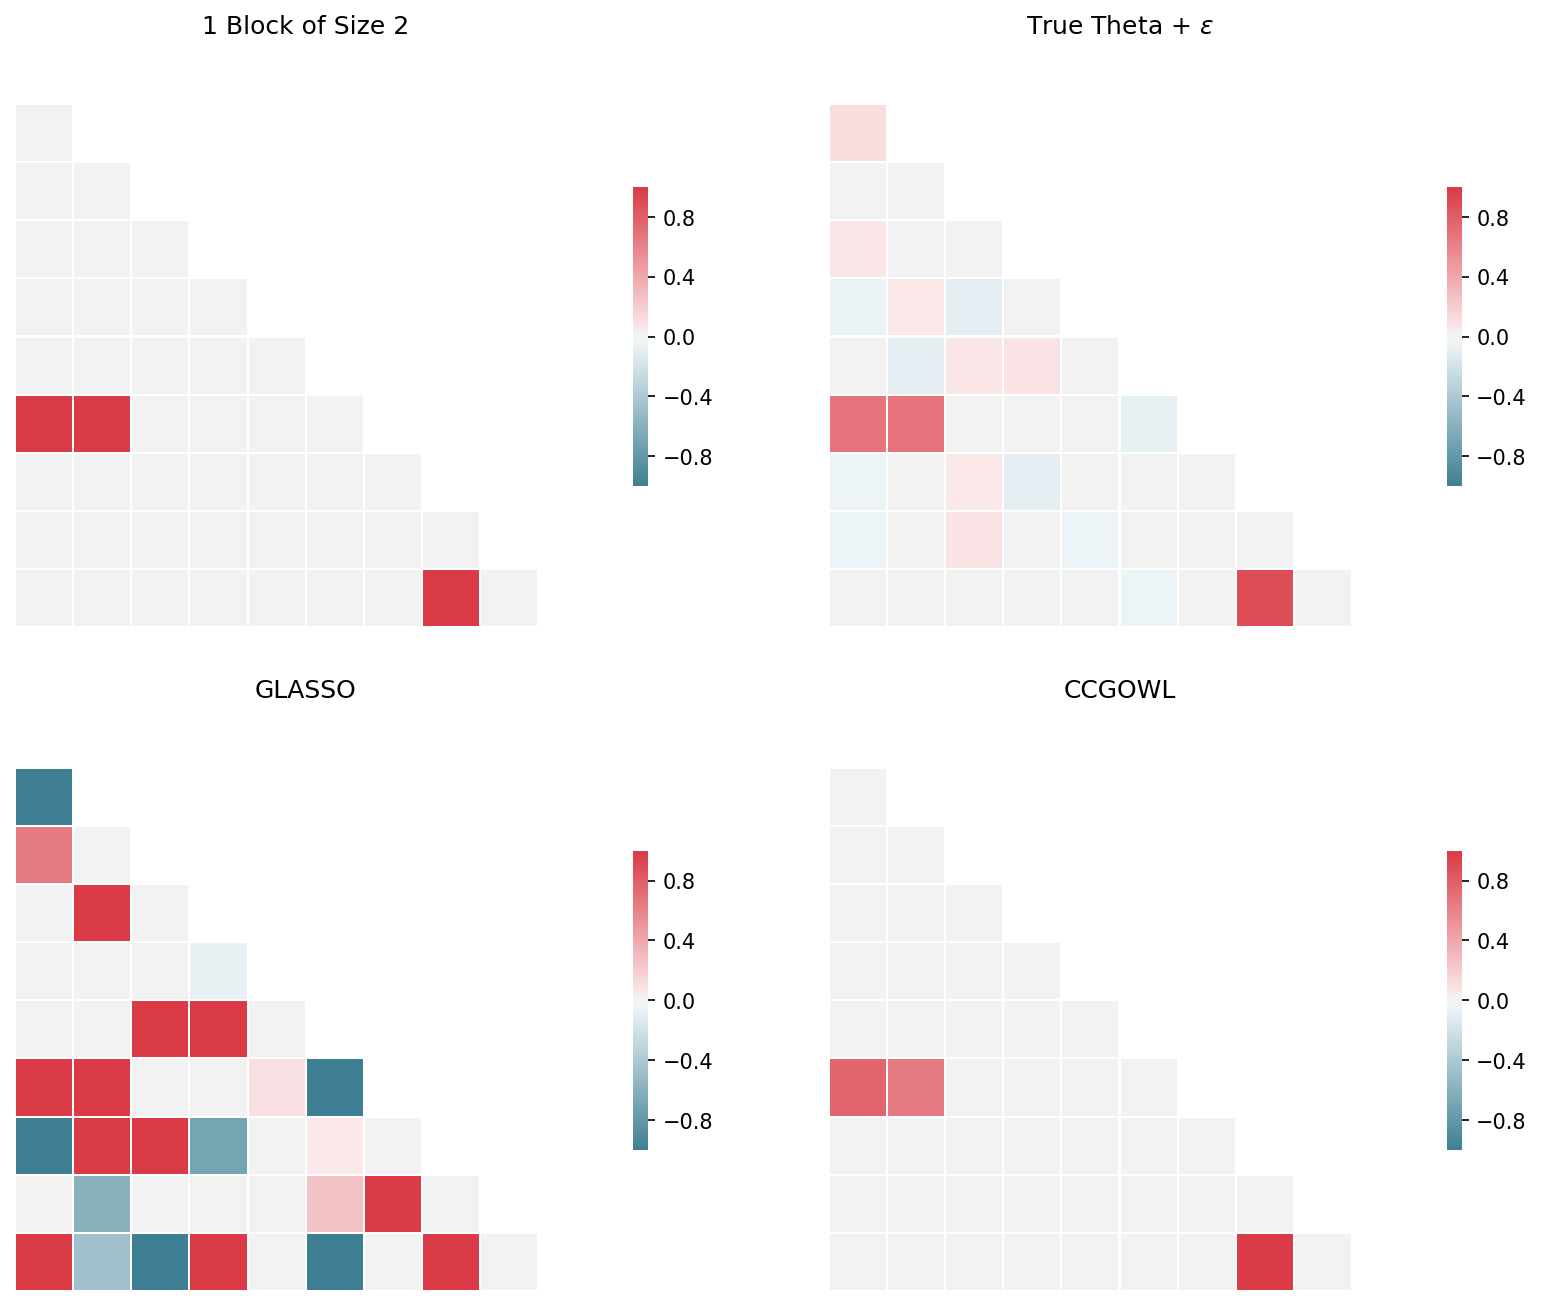

In [14]:
plot_multiple_theta_matrices_2d([
    theta_star, theta_star_eps, theta_glasso, theta_ccgowl
], [
    f"1 Block of Size 2", 'True Theta + $\epsilon$', 'GLASSO', 'CCGOWL'
])